# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc

%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')
MAX_HISTORY = 3  #int: no of bins to be added as history

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [4]:
def custom_r2_func(y_true, y_pred):
    "$R^2$ value as squared correlation coefficient, as per Gallego, NN 2020"
    return stats.pearsonr(y_true, y_pred)[0] ** 2

custom_r2_scorer = make_scorer(custom_r2_func)

# Decoding


Train one decoder and use it to decode velocity in other animals.  
The logic follows:  
CCA gives us: $X_1A\cong X_2B$  
Then: $X_1 \cong X_2BA^{-1}$  
So, we can train a decoder on $X_1$ and, then align any $X_2$ to $X_1$ to get $A$ and $B$.  
The same decoder should work on $X_2BA^{-1}$ as input.

---

**getting the data**

In [5]:
def get_data_array_and_vel(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> np.ndarray:
    """
    Applies PCA to the data and return a data matrix of the shape: sessions x targets x  trials x time x PCs
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyal-data
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun`
    `area`: area, either: 'M1', or 'S1', or 'PMd'

    Returns
    -------
    `AllData`: np.array

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', n_components=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    field = f'{area}_rates'
    n_shared_trial = np.inf
    for df in data_list:
        for target in range(8):
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df_,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_components))
    AllVel  = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, 2))
    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for target in range(8):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, (trial_rates,trial_vel) in enumerate(zip(df__._pca, df__.vel)):
                AllData[session,target,trial, :, :] = trial_rates
                AllVel[session,target,trial, :, :] = trial_vel
    
    return AllData, AllVel

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [18]:
pairIndex_across = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndex_across.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndex_across[-1][1].append(j)
pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

In [19]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testId in pairIndex_across:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData,MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

normalised_across_score = []
for idx1, idx2, scores in reg_scores_across:
    across_score = np.add(*scores)/2
    animal_avg = np.mean([*animal_scores[full_list[idx1][0]], *animal_scores[full_list[idx2][0]]])
    normalised_across_score.append(across_score/animal_avg)
normalised_across_score = np.array(normalised_across_score)

Text(0.5, 1.0, 'Velocity Decoding --- across animals')

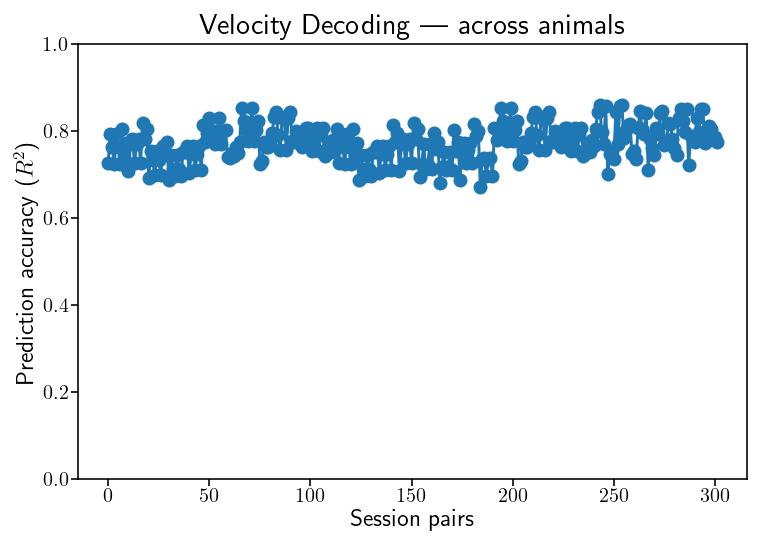

In [20]:
_,ax = plt.subplots()
ax.plot(pop_score_across,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- across animals')

Text(0.5, 1.0, 'Velocity Decoding: $\\frac{R^2_{across}}{max(R^2_{within})}$')

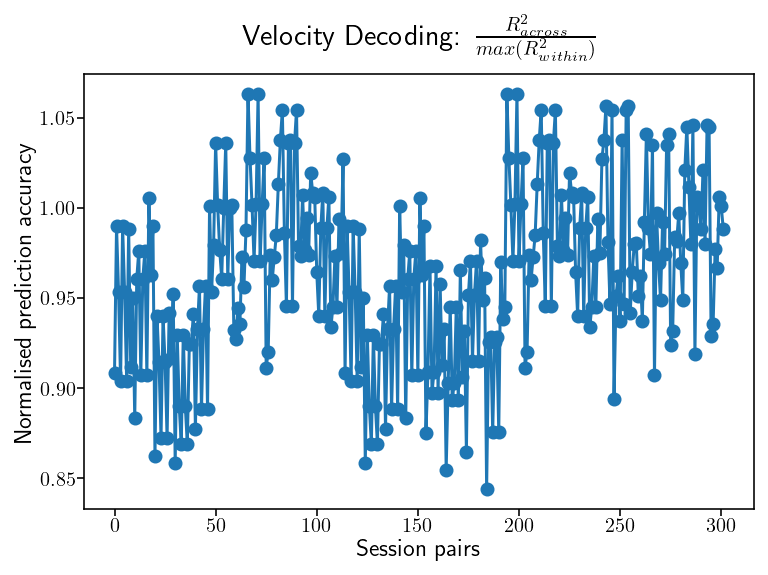

In [21]:
_,ax = plt.subplots()
ax.plot(normalised_across_score,'-o')
# ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel(r'Normalised prediction accuracy')
ax.set_title(r'Velocity Decoding: $\frac{R^2_{across}}{max(R^2_{within})}$', pad = 15)

## Without alignment

In [22]:
warnings.filterwarnings("ignore")
reg_latent_scores = []
for id1, testId in pairIndex_across:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)

    # adding history
    AllData = dt.add_history_to_data_array(AllData,MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
#     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(X2))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(X2))
    reg_latent_scores.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_latent_score = []
for _,_,scores in reg_latent_scores:
    pop_latent_score.append(np.mean(scores))
pop_latent_score = np.array(pop_latent_score)

normalised_latent_score = []
for idx1, idx2, scores in reg_latent_scores:
    across_score = np.add(*scores)/2
    animal_avg = np.mean([*animal_scores[full_list[idx1][0]], *animal_scores[full_list[idx2][0]]])
    normalised_latent_score.append(across_score/animal_avg)
normalised_latent_score = np.array(normalised_latent_score)

Text(0.5, 1.0, 'Velocity Decoding --- across animals without alignment')

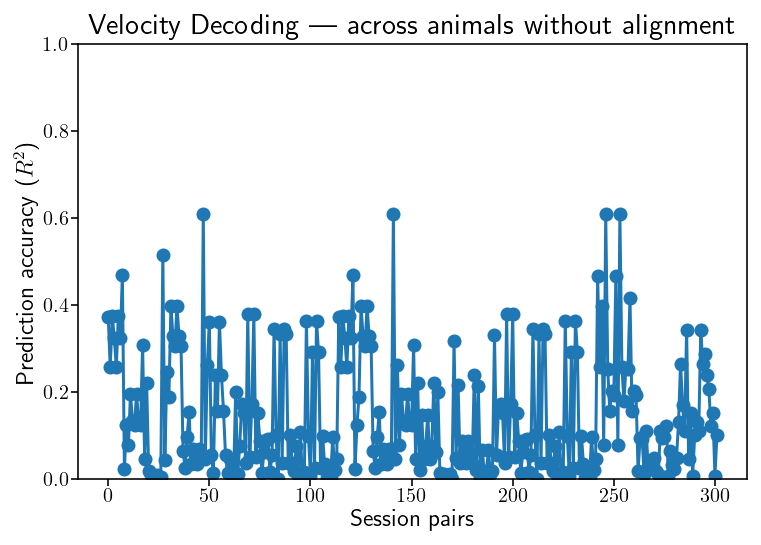

In [23]:
_,ax = plt.subplots()
ax.plot(pop_latent_score,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- across animals without alignment')

# histograms

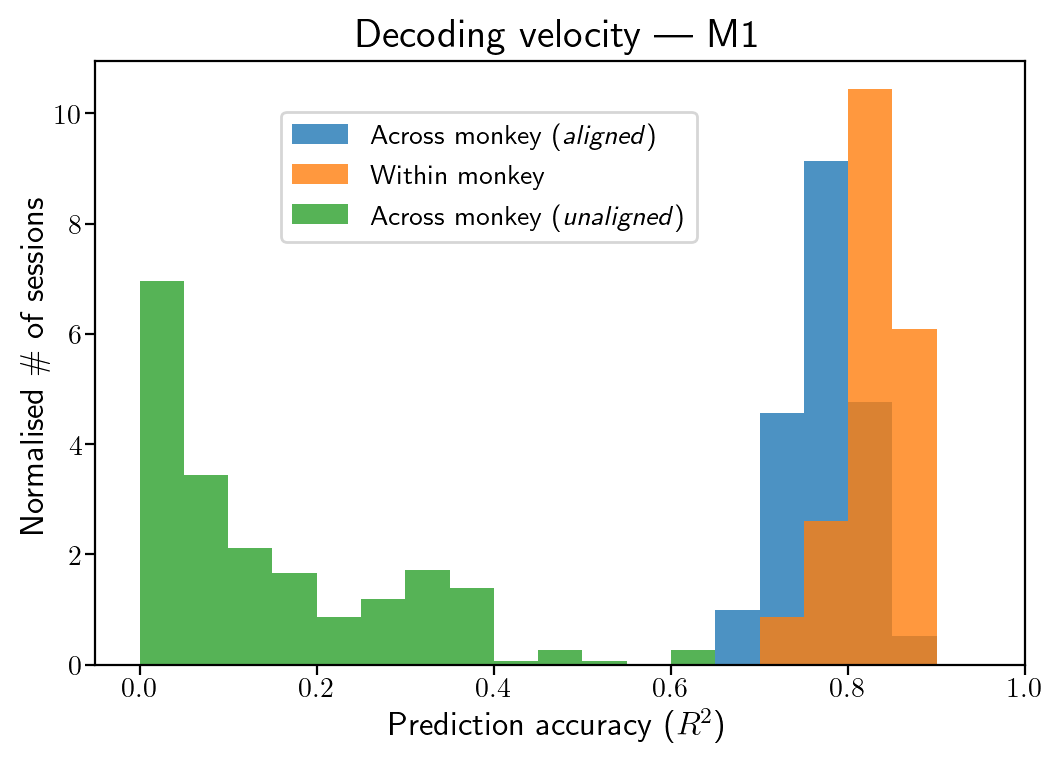

In [26]:
fig,ax = plt.subplots(dpi=100)

bins = np.arange(0,1,0.05)
ax.hist(pop_score_across, bins=bins, density=True, label=r'Across monkey (\textit{aligned})', alpha=.8)
# ax.hist(pop_score2, bins=bins, density=True, label='aligned across days', alpha=.8)
ax.hist(pop_score_day, bins=bins, density=True, label='Within monkey', alpha=.8)
ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across monkey (\textit{unaligned})', alpha=.8)

ax.set_title('Decoding velocity --- M1')
ax.set_xlabel('Prediction accuracy ($R^2$)')
ax.set_ylabel(r'Normalised \# of sessions')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([-.05,1])
ax.legend(loc=(.2,.7))